In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
import cython
warnings.filterwarnings('ignore')



sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
def _scatterer(diameters, ar, wl, j=0, rt=tmatrix.Scatterer.RADIUS_MAXIMUM, forward=True):
    """
    Function that computes the scatterer object using pytmatrix package
    :param diameters: numpy array with diameters in mm
    :param ar: numpy array with axis ratio values
    :param wl: wavelength for which scatterer will be computed. e.g "Ka"
    :param j: Zenith angle input
    :param rt: maximum radius in mm
    :param forward: True if forward scattering geometry. False will use backward scattering geometry.
    :return: list of scatterers objects
    """
    if forward:
        gm = tmatrix_aux.geom_horiz_forw
    else:
        gm = tmatrix_aux.geom_horiz_back

    if wl == "Ku":
        wlg = tmatrix_aux.wl_Ku
        m = refractive.m_w_0C[tmatrix_aux.wl_Ku]
    elif wl == "Ka":
        wlg = tmatrix_aux.wl_Ka
        m = refractive.m_w_0C[tmatrix_aux.wl_Ka]
    elif wl == "W":
        wlg = tmatrix_aux.wl_W
        m = refractive.m_w_0C[tmatrix_aux.wl_W]
    else:
        raise Exception('wl {} not valid. Please use Ka, Ku, or W'.format(wl))

    return [tmatrix.Scatterer(radius=d / 2., wavelength=wlg, m=m, axis_ratio=1.0 / ar[idx], thet0=j,
                              thet=180 - j, phi0=0., phi=180., radius_type=rt,
                              geometry=gm) for idx, d in enumerate(diameters)]


def bck_extc_crss(diameters, instrument, _lower=300, _upper=1000, ar=None, j=0) -> pd.DataFrame:
    """
    Function that computes the backscatter and extinction cross-section for a particle.
    :param diameters: numpy array of diameters (mm) to which bcksct or extc will be computed.
    :param instrument: instrument for naming the database where bcksct or extc will be stored. e.g. "2DS"
    :param _lower: min diameter.
    :param _upper: max diameter
    :param ar: axis ratio numpy array
    :param j: Zenith angle input
    :return: Pandas dataframe with backscattering and extinction cross-section for Ku, Ka, and W band radar
    """

    try:
        path_db = f'{path_data}/cloud_probes/db'
        str_db = f"sqlite:///{path_db}/scattering_{_lower}_{_upper}.sqlite"
        df_scatter = pd.read_sql(f"{instrument}", con=str_db).set_index('index')
        return df_scatter
    except (OperationalError, ValueError):
        if not ar:
            andsager_ar: Callable[[float], float] = lambda d: 1.0048 + 0.0057 * d - 2.628 * d ** 2 + 3.682 * d ** 3 - \
                                                              1.677 * d ** 4
            ar = andsager_ar(diameters / 10)

        x_ku = 2 * np.pi * (diameters / 2.) / tmatrix_aux.wl_Ku
        x_ka = 2 * np.pi * (diameters / 2.) / tmatrix_aux.wl_Ka
        x_w = 2 * np.pi * (diameters / 2.) / tmatrix_aux.wl_W

        # Tmatrix calculations
        # forward scatterer
        ku_scatter_fw = _scatterer(diameters=diameters, ar=ar, wl='Ku', j=j)
        ka_scatter_fw = _scatterer(diameters=diameters, ar=ar, wl='Ka', j=j)
        w_scatter_fw = _scatterer(diameters=diameters, ar=ar, wl='W', j=j)

        # extinction cross-section
        ku_extinction = [ext_xsect(i) for i in ku_scatter_fw]
        ka_extinction = [ext_xsect(i) for i in ka_scatter_fw]
        w_extinction = [ext_xsect(i) for i in w_scatter_fw]

        # backward scatterer
        ku_scatter_bw = _scatterer(diameters=diameters, ar=ar, wl='Ku', j=j, forward=False)
        ka_scatter_bw = _scatterer(diameters=diameters, ar=ar, wl='Ka', j=j, forward=False)
        w_scatter_bw = _scatterer(diameters=diameters, ar=ar, wl='W', j=j, forward=False)

        # Backscattering cross-section
        ku_bckscatt = [radar.radar_xsect(i) for i in ku_scatter_bw]
        ka_bckscatt = [radar.radar_xsect(i) for i in ka_scatter_bw]
        w_bckscatt = [radar.radar_xsect(i) for i in w_scatter_bw]

        # Mie calculations
        mie_ku = [Mie(x=x_ku[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ku]).qb() * np.pi * (i / 2.) ** 2 for w, i in
                  enumerate(diameters)]
        mie_ka = [Mie(x=x_ka[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ka]).qb() * np.pi * (i / 2.) ** 2 for w, i in
                  enumerate(diameters)]
        mie_w = [Mie(x=x_w[w], m=refractive.m_w_0C[tmatrix_aux.wl_W]).qb() * np.pi * (i / 2.) ** 2 for w, i in
                 enumerate(diameters)]

        df_scatter = pd.DataFrame(
            {'T_mat_Ku': ku_bckscatt, 'T_mat_Ka': ka_bckscatt, 'T_mat_W': w_bckscatt, 'Mie_Ku': mie_ku, 'Mie_Ka': mie_ka,
             'Mie_W': mie_w, 'Ku_extc': ku_extinction, 'Ka_extc': ka_extinction, "W_extc": w_extinction}, index=diameters)
        path_db = f'{path_data}/cloud_probes/db'
        make_dir(path_db)
        str_db = f"sqlite:///{path_db}/scattering_{_lower}_{_upper}.sqlite"
        df_scatter.to_sql(f'{instrument}', con=str_db, if_exists='replace')
        return df_scatter

In [4]:
def integral(dm, d, dd, mu=3, instrument='Composite_PSD', mie=False, band='Ku'):
    if mie is False:
        sct = f'T_mat_{band}'
    else:
        sct = f'Mie_{band}'
    bsc = bck_extc_crss(d.values, instrument=instrument)
    sigma_b = xr.DataArray(data=bsc[sct],
                           dims=['diameter'],
                           coords=dict(diameter=(["diameter"], d.diameter.values)))
    f_mu = (6. * (mu + 4.) ** (mu + 4.)) / (4. ** 4 * gamma(mu + 4.))
    i_b = sigma_b * f_mu * (d / dm) ** mu * np.exp(-(mu + 4.) * (d / dm)) * dd
    return i_b.sum('diameter')


def dfr_func(dm, xr_comb, mu=3):
    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    ib_ku = integral(dm=dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=mu, band="Ku")
    ib_ka = integral(dm=dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=mu, band="Ka")
    ku = 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * np.log10(((ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ka))
    return ku - ka

def ib_cal(dm, xr_comb):
    ku_wvl = c / 14e9 * 1000
    ib = integral(dm=dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=3, band="Ku")
    return 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib))


def equ_func(dm, xr_comb, mu=3):
    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    ib_ku = integral(dm=dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=mu, band="Ku")
    ib_ka = integral(dm=dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=mu, band="Ka")
    ku = 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * np.log10(((ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ka))
    dfr = xr_comb.dbz_t_ka - xr_comb.dbz_t_ku
    return dfr - ku + ka


In [5]:
cluster = SLURMCluster(queue="seseml",
                       memory='20GB',
                       cores=20,
                       processes=1,
                       walltime='24:00:00',
#                        scheduler_options={
#                            'host': '172.22.179.3:7225', 
#                            'dashboard_address': ':7799'
#                        }
                      )

cluster.scale(jobs=2)
cluster

In [6]:
client = Client(cluster)
client

<Client: 'tcp://172.22.179.144:43128' processes=0 threads=0, memory=0 B>

In [7]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1642729    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1642728    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1642487    seseml interact alfonso8  R    6:02:38      1 keeling-j34
           1642718    seseml dask-wor alfonso8  R    1:24:10      1 keeling-j03
           1642719    seseml dask-wor alfonso8  R    1:24:10      1 keeling-j04


In [8]:
aircraft = 'Lear'
aircraft2 = 'Learjet'

In [9]:
store5 = f"{path_data}/cloud_probes/zarr/Page0_Learjet.zarr"
store8 = f"{path_data}/cloud_probes/zarr/combined_psd_{aircraft}_600_1000_5_bins_merged.zarr"

In [10]:
xr_comb  = xr.open_zarr(store8)#.sel(time=slice('2019-09-07 2:31:45', '2019-09-07 2:33:45'))
# xr_comb = xr_comb.isel(time=range(10, 21))
xr_comb.attrs['instrument'] = 'combined_psd_2ds_hvps'


In [11]:
def equ_func(dm, d, d_d, dfr, mu):
    ku_wvl = c / 13.6e9 * 1000
    ka_wvl = c / 35.5e9 * 1000
    ib_ku = integral(dm=dm, d=d, dd=d_d, mu=mu, band="Ku")
    ib_ka = integral(dm=dm, d=d, dd=d_d, mu=mu, band="Ka")
    ku = 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * np.log10(((ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ka))
    return dfr - ku + ka


In [12]:
%load_ext Cython

In [13]:
%%cython --compile-args=-Ofast --compile-args=-fopenmp --link-args=-fopenmp
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp, log10, pi
from cython.parallel cimport prange
from pytmatrix import tmatrix_aux
from scipy.special.cython_special cimport gamma

cdef double ku_wvl, ka_wvl
cdef double [:] d , dd, sigma_b_ka, sigma_b_ku, z_ku, z_ka
d = np.load('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/np_arr/d.npy')
dd = np.load('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/np_arr/dd.npy')
sigma_b_ka = np.load('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/np_arr/sigma_b_ka.npy')
sigma_b_ku = np.load('/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/np_arr/sigma_b_ku.npy')
ku_wvl= tmatrix_aux.wl_Ku
ka_wvl = tmatrix_aux.wl_Ka


@cython.cdivision(True)
cdef double int_ku(double dm, float mu=3.0):
    cdef double f_mu, den, num, gam, i_b, acc
    cdef Py_ssize_t n = d.shape[0]
    cdef Py_ssize_t i
    gam = gamma(mu + 4)
    num = 6 * (mu + 4) ** (mu + 4)
    den = 4 ** 4 * gam
    f_mu = num / den
    for i in prange(n, nogil=True):
        i_b += sigma_b_ku[i] * f_mu * (d[i] / dm) ** mu * exp(-(mu + 4) * (d[i] / dm)) * dd[i]
    return i_b

@cython.cdivision(True)
cdef double int_ka(double dm, float mu=3.0):
    cdef double f_mu, den, num, gam, i_b
    cdef Py_ssize_t n = d.shape[0]
    cdef Py_ssize_t i
    gam = gamma(mu + 4)
    num = 6 * (mu + 4) ** (mu + 4)
    den = 4 ** 4 * gam
    f_mu = num / den
    for i in prange(n, nogil=True):
        i_b += sigma_b_ka[i] * f_mu * (d[i] / dm) ** mu * exp(-(mu + 4) * (d[i] / dm)) * dd[i]
    return i_b

@cython.cdivision(True)
cdef double dfr_calc(double dm, float mu=3.0):
    cdef double ka, ku, ib_ku, ib_ka
    ib_ku = int_ku(dm=dm, mu=mu)
    ib_ka = int_ka(dm=dm, mu=mu)
    ku = 10 * log10(((ku_wvl ** 4 / (pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * log10(((ka_wvl ** 4 / (pi ** 5 * 0.93)) * ib_ka)) 
    return ku - ka

@cython.cdivision(True)
cdef double eq_func(double dm, double dfr, float mu=3.0):
    cdef double ka, ku, ib_ku, ib_ka
    ib_ku = int_ku(dm=dm, mu=mu)
    ib_ka = int_ka(dm=dm, mu=mu)
    ku = 10 * log10(((ku_wvl ** 4 / (pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * log10(((ka_wvl ** 4 / (pi ** 5 * 0.93)) * ib_ka))
    return ku - ka

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.cdivision(True)
def dm_sol(double [:] mu, double [:] dm, double dfr):
    cdef const double[:] mu_view = mu.copy()
    cdef const double[:] dm_view = dm.copy()
    x_max = mu_view.shape[0]
    y_max = dm_view.shape[0]
    cdef double [:,:] res = np.zeros((x_max, y_max), dtype=np.double)
    cdef double[:, :] result_view = res
    cdef Py_ssize_t m = mu_view.shape[0]
    cdef Py_ssize_t n = dm_view.shape[0]
    cdef Py_ssize_t i
    cdef Py_ssize_t j
    for i in range(m):
        for j in range(n):
            result_view[i, j] =  eq_func(dm=dm[j], dfr=dfr, mu=mu[i])
    return res

In [14]:
d = xr_comb.diameter / 1e3
d_d = xr_comb.d_d / 1e3

In [24]:
# np.atleast_1d(xr_comb.mu.values).astype('float64')
dfr_array = np.arange(-2.5, 5, 0.1).astype('float64')
dm_array = np.arange(0, 5, 0.1).astype('float64')
mu_array = np.arange(-4.5, 0, 1).astype('float64')
mu_array_2= np.array([1, 3, 8]).astype('float64')

In [25]:
test = np.array(dm_sol(dm=dm_array, mu=mu_array, dfr=0))
test2 = np.array(dm_sol(dm=dm_array, mu=mu_array_2, dfr=0))

In [21]:
# dfr_dm = np.array(res).reshape([mu_array.shape[0],dm_array.shape[0]])

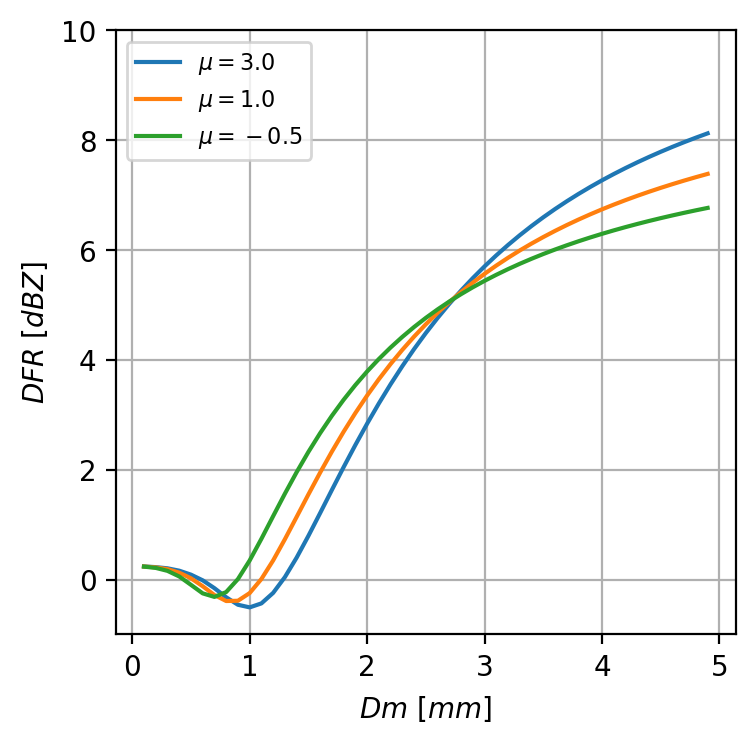

In [39]:
fig, ax = plt.subplots(dpi=200, figsize=(4, 4))
# ax.plot(dm_array, test2[-1, :],  c='C5', label=f'$\mu = {mu_array_2[-1]}$')
ax.plot(dm_array, test2[1, :],  c='C0', label=f'$\mu = {mu_array_2[1]}$')
ax.plot(dm_array, test2[0, :],  c='C1', label=f'$\mu = {mu_array_2[0]}$')
ax.plot(dm_array, test[4, :], c='C2', label=f'$\mu = {mu_array[4]}$')

# ax.plot(dm_array, test[3, :], c='C3', label=f'$\mu = {mu_array[3]}$')
# ax.plot(dm_array, test[2, :], c='C4', label=f'$\mu = {mu_array[2]}$')
# ax.plot(dm_array, test[1, :], c='C3', label=f'$\mu = {mu_array[1]}$')

ax.set_xlabel('$Dm \ [mm]$')
ax.set_ylabel('$DFR \ [dBZ]$')
ax.legend(fontsize = '8')
# ax.set_xlim(0, 4)
ax.set_ylim(-1, 10)
ax.grid('both')

In [18]:
xr_comb.dm.max().values

array(2.57403348)

In [19]:
res = []
for i in mu_array:
    for j in dm_array:
        res.append(equ_func(dm=j, d=d, d_d=d_d, dfr=10, mu=i).values) 
        
dfr_dm = np.array(res).reshape([mu_array.shape[0],dm_array.shape[0]])

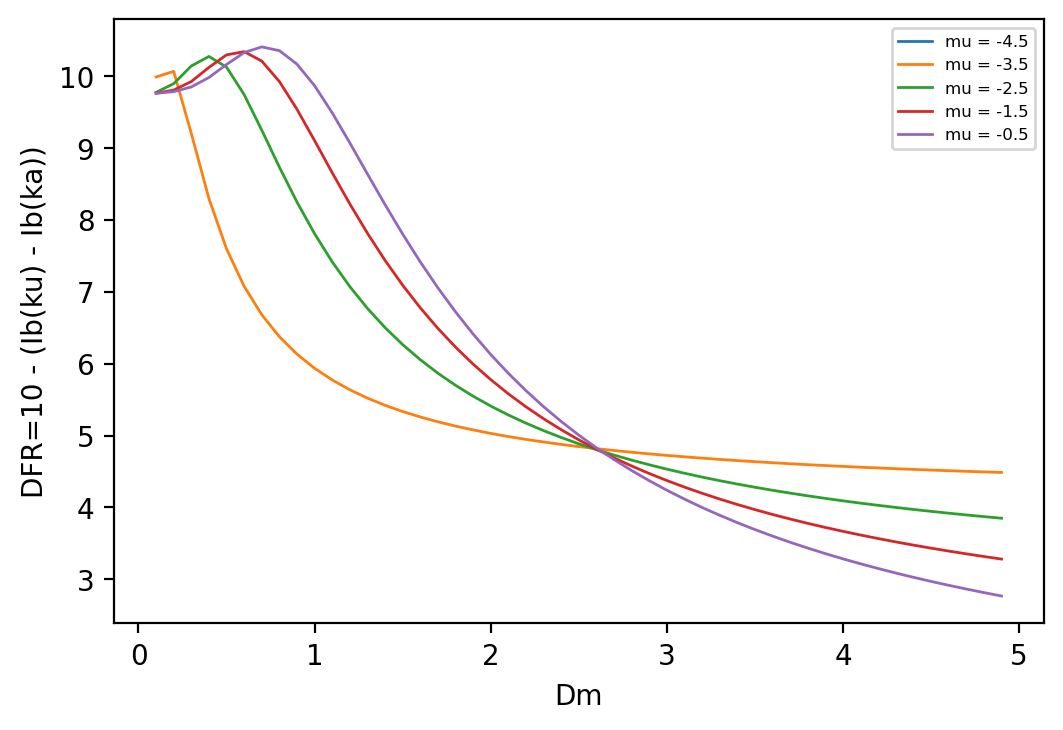

In [20]:
fig, ax = plt.subplots(dpi=200)
for i in range(dfr_dm.shape[0]):
    ax.plot(dm_array, dfr_dm[i, :], label=f'mu = {mu_array[i]}', lw=1)

ax.set_xlabel('Dm')
ax.set_ylabel('DFR=10 - (Ib(ku) - Ib(ka))')
ax.legend(fontsize = '6')

In [21]:
res = []
for i in mu_array:
    for j in dm_array:
        res.append(equ_func(dm=j, d=d, d_d=d_d, dfr=-3, mu=i).values) 
        
dfr_dm = np.array(res).reshape([mu_array.shape[0],dm_array.shape[0]])

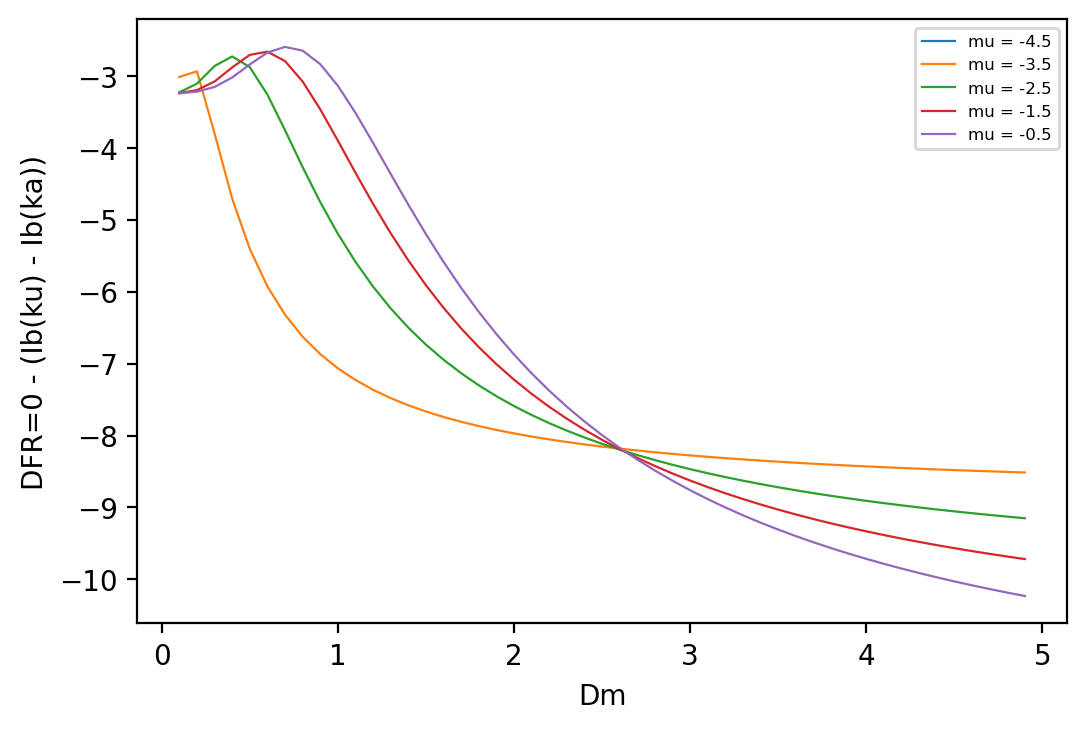

In [22]:
fig, ax = plt.subplots(dpi=200)
for i in range(dfr_dm.shape[0]):
    ax.plot(dm_array, dfr_dm[i, :], label=f'mu = {mu_array[i]}', lw=.8)

ax.set_xlabel('Dm')
ax.set_ylabel('DFR=0 - (Ib(ku) - Ib(ka))')
ax.legend(fontsize = '6')

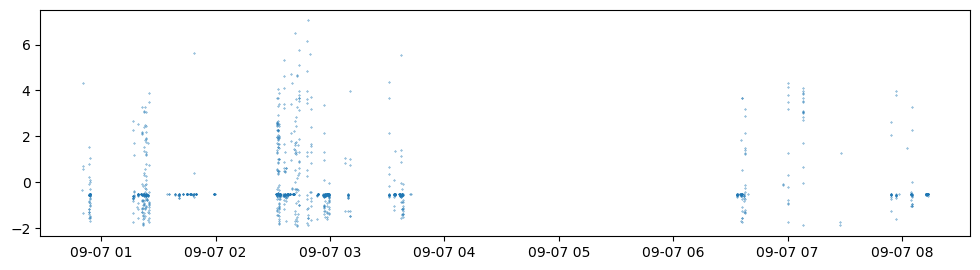

In [23]:
xr_test = xr_comb.sel(time='2019-09-07')
fig, ax = plt.subplots(figsize=(12, 3), dpi=100)
ax.scatter(xr_test.time, xr_test.dbz_t_ku - xr_test.dbz_t_ka, s=0.1)

In [24]:
def equ_func2(dm, d, d_d, mu=3):
    ku_wvl= tmatrix_aux.wl_Ku
    ka_wvl = tmatrix_aux.wl_Ka
    ib_ku = integral(dm=dm, d=d, dd=d_d, mu=mu, band="Ku")
    ib_ka = integral(dm=dm, d=d, dd=d_d, mu=mu, band="Ka")
    ku = 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ku))
    ka = 10 * np.log10(((ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * ib_ka))
    return ku - ka

In [25]:
res = []
for i in mu_array:
    for j in dm_array:
        res.append(equ_func2(dm=j, d=d, d_d=d_d, mu=i).values) 
        
dfr_dm = np.array(res).reshape([mu_array.shape[0],dm_array.shape[0]])

(0.0, 3.0)

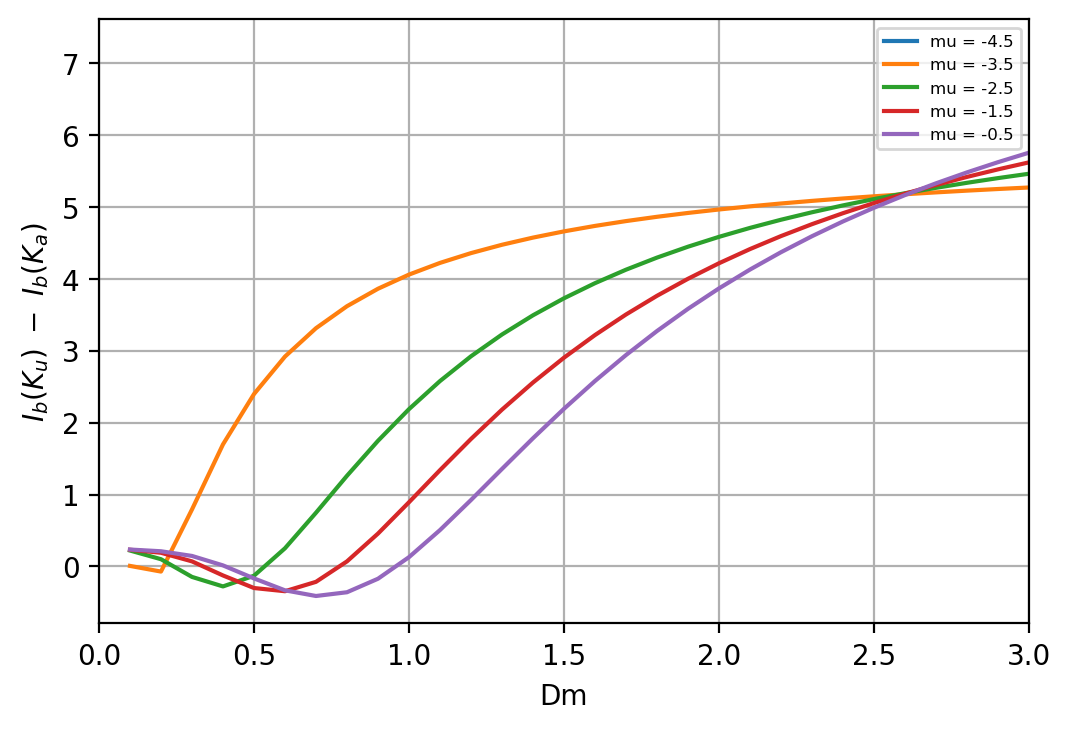

In [26]:
fig, ax = plt.subplots(dpi=200)
for i in range(dfr_dm.shape[0]):
    ax.plot(dm_array, dfr_dm[i, :], label=f'mu = {mu_array[i]}')

ax.set_xlabel('Dm')
ax.set_ylabel(r'$I_b(K_u) \ - \  I_b(K_a)$')
ax.legend(fontsize = '6')
ax.grid('both')
ax.set_xlim(0, 3.0)

In [27]:
dfr_est = dfr_func(dm=xr_comb.dm.load(), xr_comb=xr_comb.load(), mu=xr_comb.mu.load())

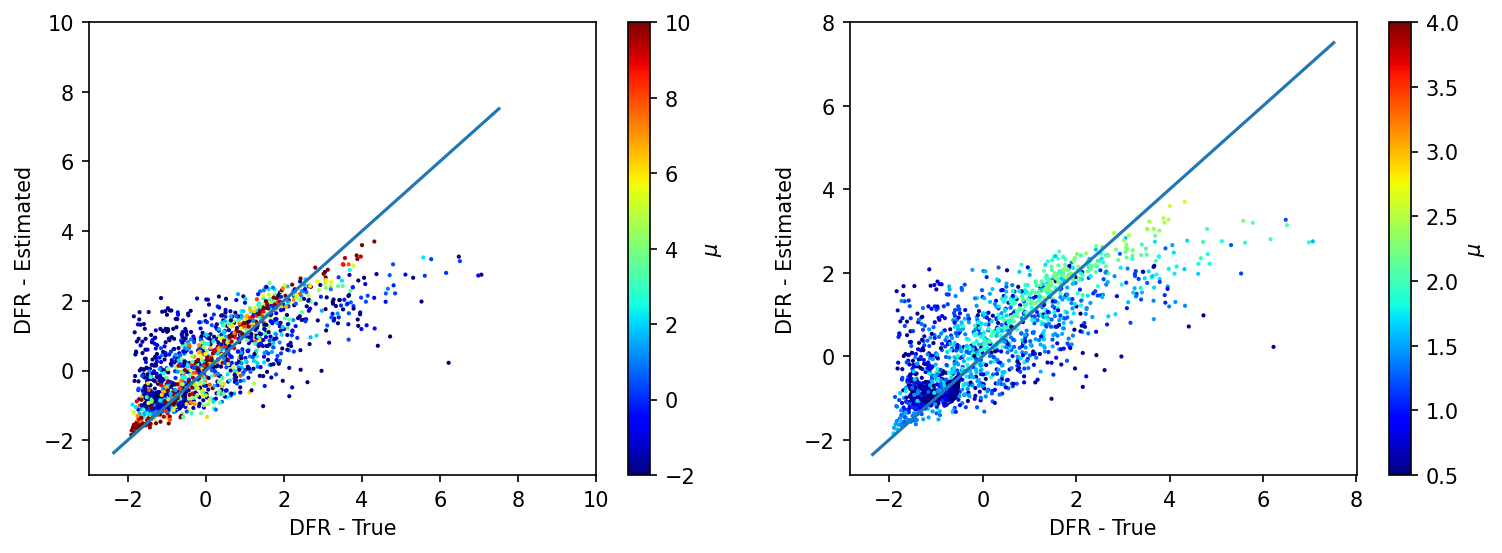

In [28]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=150, figsize=(12,4))
sc = ax.scatter(xr_comb.dfr.load(), dfr_est.load(), s=1, c=xr_comb.mu, vmin=-2, vmax=10, cmap='jet')
ax.set_ylabel('DFR - Estimated')
ax.set_xlabel('DFR - True')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

sc1 = ax1.scatter(xr_comb.dfr.load(), dfr_est.load(), s=1, c=xr_comb.dm, vmin=0.5, vmax=4, cmap='jet')
ax1.set_ylabel('DFR - Estimated')
ax1.set_xlabel('DFR - True')
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x)
ax.set_xlim(-3, 10)
ax.set_ylim(-3, 10)
fig.colorbar(sc, ax=ax, label=r'$\mu$')
fig.colorbar(sc1, ax=ax1, label=r'$\mu$')


In [29]:
xr_comb

<xarray.Dataset>
Dimensions:    (time: 4046, diameter: 58)
Coordinates:
  * diameter   (diameter) float64 50.0 60.0 70.0 ... 3.524e+03 3.824e+03
  * time       (time) datetime64[ns] 2019-09-07T00:50:13 ... 2019-09-29T04:31:27
Data variables: (12/33)
    A_ka       (time, diameter) float64 nan nan nan nan nan ... nan nan nan nan
    A_ku       (time, diameter) float64 nan nan nan nan nan ... nan nan nan nan
    A_w        (time, diameter) float64 nan nan nan nan nan ... nan nan nan nan
    Att_ka     (time) float64 3.066 4.286 3.381 6.293 ... 7.688 5.534 -3.644
    Att_ku     (time) float64 -6.083 -4.623 -6.35 ... -0.8796 -2.341 -11.91
    Att_w      (time) float64 8.842 10.7 11.37 11.94 ... 13.9 13.27 12.54 4.181
    ...         ...
    sigma      (time) float64 0.6386 0.6475 0.2685 ... 0.7562 0.8283 0.216
    sigmap     (time) float64 0.5239 0.5276 0.254 ... 0.5586 0.7625 0.5319
    sigmasqr   (time) float64 0.4079 0.4193 0.07207 ... 0.5718 0.686 0.04664
    temp       (time) float64 20.2 20.2 19.2 18.9 18.7 ... 3.0 2.4 2.4 2.3 2.3
    vert_vel   (time) float64 -0.2 -0.4 -0.6 -0.5 -0.4 ... -1.2 -0.8 0.1 1.7
    z          (time, diameter) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    LWC:              units gm-3
    RH:               method Lear-Computed, P3B-Measured
    altitude:         units Lear (ft), P3B (m)
    combined_pds:     units: # l um-1
    d_d:              bin lenght in mm
    dew_point:        units Celcius
    ...               ...
    reflectivity_Ku:  units mm6 mm-3
    reflectivity_W:   units mm6 mm-3
    temp:             units Celcius
    time:             UTC
    vert_vel:         units ms-1
    instrument:       combined_psd_2ds_hvps

In [30]:
def z_func(xr_comb):
    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    ib_ku = integral(dm=xr_comb.dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=xr_comb.mu, band="Ku")
    ib_ka = integral(dm=xr_comb.dm, d=xr_comb.diameter / 1e3, dd=xr_comb.d_d / 1e3, mu=xr_comb.mu, band="Ka")
    ku = 10 * np.log10(((ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * xr_comb.nw * ib_ku))
    ka = 10 * np.log10(((ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * xr_comb.nw * ib_ka))
    return ku, ka

In [31]:
z_ku_norm, z_ka_norm =  z_func(xr_comb.load())

Text(0, 0.5, 'Z_Ka (Norm-Gamma)')

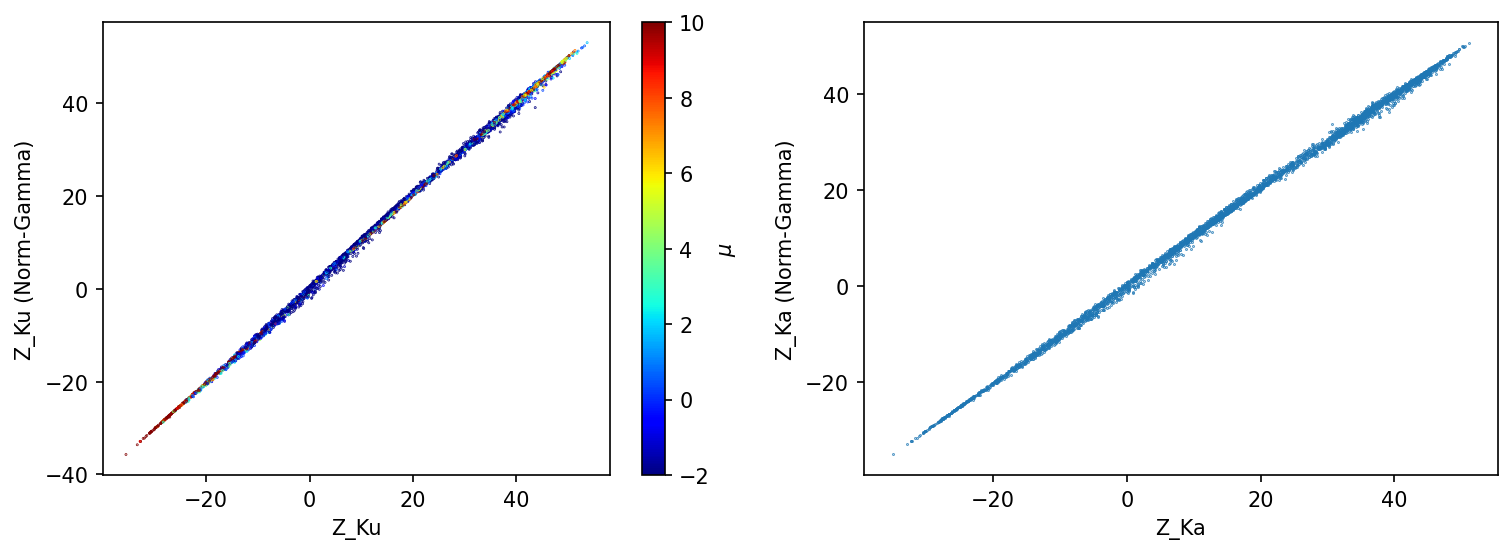

In [32]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
sc = ax.scatter(xr_comb.dbz_t_ku, z_ku_norm, s=0.1, c=xr_comb.mu, cmap='jet', vmin=-2, vmax=10)
ax.set_xlabel('Z_Ku')
ax.set_ylabel('Z_Ku (Norm-Gamma)')
fig.colorbar(sc, ax=ax, label=r'$\mu$')
ax1.scatter(xr_comb.dbz_t_ka, z_ka_norm, s=0.1)
ax1.set_xlabel('Z_Ka')
ax1.set_ylabel('Z_Ka (Norm-Gamma)')

In [33]:
dfr_norm = z_ku_norm - z_ka_norm
xr_comb['dfr'] = xr_comb.dbz_t_ku - xr_comb.dbz_t_ka

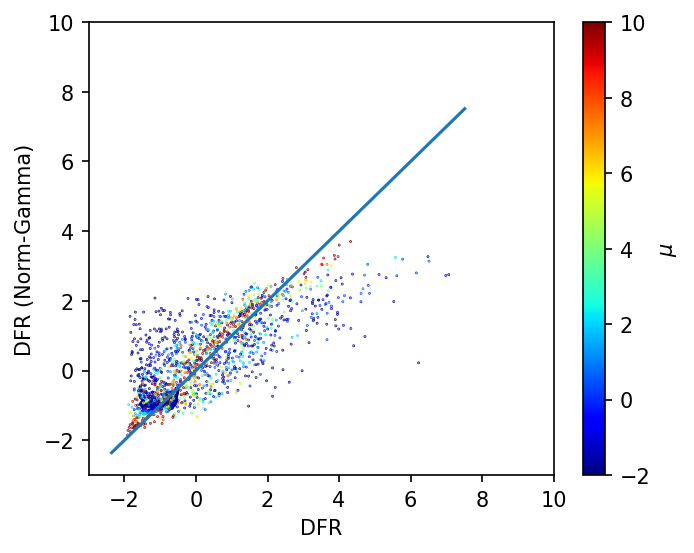

In [34]:
fig, ax = plt.subplots(1, figsize=(5, 4), dpi=150)
sc = ax.scatter(xr_comb.dfr, dfr_norm, s=0.1, c=xr_comb.mu, cmap='jet', vmin=-2, vmax=10)
ax.set_xlabel('DFR')
ax.set_ylabel('DFR (Norm-Gamma)')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
ax.set_xlim(-3, 10)
ax.set_ylim(-3, 10)
fig.colorbar(sc, ax=ax, label=r'$\mu$')